# Анализ воронки продаж продуктов питания через мобильное приложение. Оценка результатов A/A/B-тестирования

**Цель исследования:**
- провести анализ воронки продаж; 
- оценить результаты A/A/B-тестирования.

**Ход исследования:**
 1. Ознакомление с данными из файлов.
 2. Подготовка данных.
 3. Изучение и проверка данных.
 4. Изучение воронки событий.
 5. Изучение результатов эксперимента.
 6. Вывод.
 
**Источник данных:** данные использования мобильного приложения для продажи продуктов питания.

## Ознакомление с данными из файлов

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

import math as mth

from plotly import graph_objects as go 

from scipy import stats as st

In [61]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [62]:
font = {'family': 'DejaVu Sans',
        'color':  '#000080',
        'weight': 'normal',
        'size': 20,
        }
font_2 = {'family': 'DejaVu Sans',
        'color':  '#000000',
        'weight': 'normal',
        'size': 16,
        }

In [63]:
def data_info(data):
        print(data.info())
        print()
        print(data.head(10))
        print()
        print('Количество дубликатов:', data.duplicated().sum())

In [64]:
df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t') #чтение файла с данными и сохранение в users
data_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
5         CartScreenAppear  6217807653094995999      1564055323    248
6       OffersScreenAppear  8351860793733343758      1564066242    

**Вывод:**

- Таблица df имеет 244 126 строк и 4 столбца. В таблице нет пропусков.

- Данные в таблице имеют типы int64, object.

- Необходимо добавить столбец с датой события.

- Названия столбцов необходимо привести к змеиному регистру

## Подготовка данных

### Заменим названия столбцов

In [65]:
df = df.rename(columns={'EventName':'event_name',
                        'DeviceIDHash':'user_id',
                        'EventTimestamp':'event_timestamp',
                        'ExpId':'exp_id',
                       })
print(df.columns.tolist())

['event_name', 'user_id', 'event_timestamp', 'exp_id']


### Проверим пропуски и типы данных

### Удалим дубликаты

In [66]:
df = df.drop_duplicates().reset_index(drop=True)

### Добавим столбец даты и времени, а также отдельный столбец дат

In [67]:
df['date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['date_time'].astype('datetime64[D]')
df.head(5)

event_name              user_id  event_timestamp  exp_id  \
0         MainScreenAppear  4575588528974610257       1564029816     246   
1         MainScreenAppear  7416695313311560658       1564053102     246   
2  PaymentScreenSuccessful  3518123091307005509       1564054127     248   
3         CartScreenAppear  3518123091307005509       1564054127     248   
4  PaymentScreenSuccessful  6217807653094995999       1564055322     248   

            date_time       date  
0 2019-07-25 04:43:36 2019-07-25  
1 2019-07-25 11:11:42 2019-07-25  
2 2019-07-25 11:28:47 2019-07-25  
3 2019-07-25 11:28:47 2019-07-25  
4 2019-07-25 11:48:42 2019-07-25

## Изучение и проверка данных

### Сколько всего событий в логе?

In [68]:
print('Всего событий в логе:', df.shape[0])

Всего событий в логе: 243713


### Сколько всего пользователей в логе?

In [69]:
print('Всего пользователей в логе:', df['user_id'].nunique())

Всего пользователей в логе: 7551


### Сколько в среднем событий приходится на пользователя?

In [70]:
print('В среднем событий на пользователя:', round((df.shape[0] / df['user_id'].nunique())))

В среднем событий на пользователя: 32


Рассмотрим количество событий на одного пользователя так же при помощи графика boxplot и метода describe.

In [71]:
df_user = df.groupby('user_id')['event_name'].count().reset_index().rename(columns={'event_name': 'evenet_sum'})
df_user

user_id  evenet_sum
0        6888746892508752           1
1        6909561520679493           5
2        6922444491712477          47
3        7435777799948366           6
4        7702139951469979         137
...                   ...         ...
7546  9217594193087726423           9
7547  9219463515465815368          17
7548  9220879493065341500           7
7549  9221926045299980007           7
7550  9222603179720523844          59

[7551 rows x 2 columns]

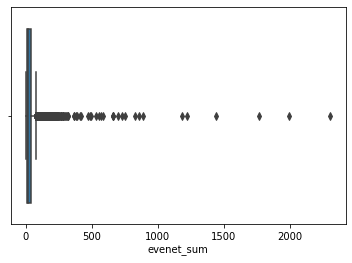

In [72]:
ax = sns.boxplot(x=df_user['evenet_sum'])

In [73]:
df_user['evenet_sum'].describe()

count   7,551.00
mean       32.28
std        65.15
min         1.00
25%         9.00
50%        20.00
75%        37.00
max     2,307.00
Name: evenet_sum, dtype: float64

На графике видно, что большинство пользователей совершают количество событий, в пределах 50. Так же есть выбросы - пользователи совершающие более 500 событий. Данные, полученные из метода describe так же говорят о выбросах, т.к. медианное значение равно 20, а среднее сильно смещено вверх относительно медианного и равно 32.

### Найдем максимальную и минимальную дату

In [74]:
min_date = df['date'].min().date()
print('Минимальная дата', min_date)
print()
max_date = df['date'].max().date()
print('Максимальная дата', max_date)

Минимальная дата 2019-07-25

Максимальная дата 2019-08-07


### Данными за какой период мы располагаем?

In [75]:
print('Мы располагаем данными за период с', min_date, 'по', max_date) 

Мы располагаем данными за период с 2019-07-25 по 2019-08-07


### Построим гистограмму по дате и времени

In [76]:
plt.figure(figsize = (16, 9))
ax = df['date_time'].hist(bins = 14)
plt.title('Гистограмма по дате и времени', fontdict=font)
plt.ylabel("Частота", fontdict=font_2)
plt.ylabel("Дата", fontdict=font_2)
plt.xticks(rotation=45)
plt.show()

### Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные»

На графике видна значительная разница между количеством событий для дней до 2019-08-01 и после этой даты. Вероятно, данные до 2019-08-01 неполные. Оставим в датафрейме только даные за период с 2019-08-01 по 2019-08-07.

In [77]:
df_work = df.loc[df['date'] > '2019-07-31']

### Определим, с какого момента данные полные и отбросим более старые. Данными за какой период времени мы располагаем на самом деле?

Выполнено выше. На самом деле мы располагаем данными за период с 2019-08-01 по 2019-08-07.

### Много ли событий и пользователей мы потеряли, отбросив старые данные?

In [78]:
print('Всего событий в логе до чистки:', df.shape[0])
print('Всего событий в логе после чисти:', df_work.shape[0])
print('Потеряно событий:', "{:.2%}".format(1 - df_work.shape[0]/df.shape[0]))

Всего событий в логе до чистки: 243713
Всего событий в логе после чисти: 240887
Потеряно событий: 1.16%


In [79]:
print('Всего пользователей в логе:', df['user_id'].nunique())
print('Всего пользователей в логе:', df_work['user_id'].nunique())
print('Потеряно пользователей:', "{:.2%}".format(1 - df_work['user_id'].nunique()/df['user_id'].nunique()))

Всего пользователей в логе: 7551
Всего пользователей в логе: 7534
Потеряно пользователей: 0.23%


### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп

In [80]:
df_work.groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()

exp_id  user_id
0     246     2484
1     247     2513
2     248     2537

Пользователи есть во всех трех экспериментальных группах.

### Вывод:

- всего в логе 243713 событий и 7751 пользователь;
- среднее количество событий на пользователя - 32, однако имеются выбросы (пользователи, совершившие 500 и более событий);
- медианное количесвто событий на пользователя - 20;
- в лог включены события за период с 2019-07-25 по 2019-08-07; однако события до 2019-08-01 мы исключили из исследования, т.к. это события "из прошлого", не относящиеся к эксперименту;
- при очистке лога от неактуальных событий мы потеряли 1,16% событий и 0,23% пользователей;
- пользователи есть в каждой из экспериментальных групп.

## Изучение воронки событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [81]:
df_work.groupby('event_name').agg({'event_timestamp': 'count'}).reset_index().sort_values('event_timestamp', ascending=False)

event_name  event_timestamp
1         MainScreenAppear           117328
2       OffersScreenAppear            46333
0         CartScreenAppear            42303
3  PaymentScreenSuccessful            33918
4                 Tutorial             1005

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [82]:
df_work.groupby('event_name').agg({'user_id': 'nunique'}).reset_index().sort_values('user_id', ascending=False)

event_name  user_id
1         MainScreenAppear     7419
2       OffersScreenAppear     4593
0         CartScreenAppear     3734
3  PaymentScreenSuccessful     3539
4                 Tutorial      840

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

События можно выстроить в следующую цепочку:
- MainScreenAppear (Главный экран)
- OffersScreenAppear (Экран предложения)
- CartScreenAppear (Корзина)
- PaymentScreenSuccessful (Экран успешной оплаты)

Этап Tutorial (Руководство пользователя) можно пропустить.

Уберем событие 'Tutorial' из данных

In [83]:
df_work = df_work[df_work['event_name'] != 'Tutorial']

Запишем воронку в переменную

In [84]:
df_work_funnel = df_work.groupby('event_name').agg({'user_id': 'nunique'}).reset_index().sort_values('user_id', ascending=False)
df_work_funnel

event_name  user_id
1         MainScreenAppear     7419
2       OffersScreenAppear     4593
0         CartScreenAppear     3734
3  PaymentScreenSuccessful     3539

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

In [85]:
fig = go.Figure(
    go.Funnel(
        y=df_work_funnel['event_name'],
        x=df_work_funnel['user_id'],
        textinfo = "value+percent initial+percent previous"
    )
)
fig.show()

In [86]:
df_work_funnel['percent_initial'] = df_work_funnel['user_id']/df_work_funnel.reset_index().loc[0]['user_id']*100
df_work_funnel

event_name  user_id  percent_initial
1         MainScreenAppear     7419           100.00
2       OffersScreenAppear     4593            61.91
0         CartScreenAppear     3734            50.33
3  PaymentScreenSuccessful     3539            47.70

### На каком шаге теряете больше всего пользователей?

Больше всего пользователей теряется на шаге OffersScreenAppear (Экран предложения) - 38%.

### Какая доля пользователей доходит от первого события до оплаты?

От первого события до оплаты доходит 48% пользователей.

## Изучение результатов эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [87]:
df_work.groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()

exp_id  user_id
0     246     2483
1     247     2512
2     248     2535

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247

#### Критерии успешного A/A-теста:

- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

Для проверки критериев разделим датасет на три.

In [88]:
exp_246 = df_work[(df_work['exp_id'] == 246)]
exp_247 = df_work[(df_work['exp_id'] == 247)]
exp_248 = df_work[(df_work['exp_id'] == 248)]

#### Количество пользователей в различных группах различается не более, чем на 1%

In [89]:
sum_user_246 = exp_246['user_id'].nunique()
sum_user_247 = exp_247['user_id'].nunique()

print('Количество пользователей в группе 246:', sum_user_246)
print('Количество пользователей в группе 247:', sum_user_247)
print('Разница в количестве пользователей между группами:', "{:.2%}".format(1 - sum_user_246/sum_user_247))

Количество пользователей в группе 246: 2483
Количество пользователей в группе 247: 2512
Разница в количестве пользователей между группами: 1.15%


#### Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же

Для проверки данного критерия построим две воронки

In [90]:
fig = go.Figure(
    go.Funnel(
        y=exp_246['event_name'],
        x=exp_246['user_id'],
        textinfo = "value+percent initial+percent previous"
    )
)

fig = go.Figure(
    go.Funnel(
        y=exp_247['event_name'],
        x=exp_247['user_id'],
        textinfo = "value+percent initial+percent previous"
    )
)

fig.show()

Две воронки показывают, что для обоих групп фиксируют и отправляют в систему аналитики данные об одном и том же

#### Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости

In [91]:
funnel_246 = exp_246.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'total_users'})
funnel_247 = exp_247.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame().reset_index()\
        .rename(columns={'user_id': 'total_users'})

In [92]:
funnel_247['total_users'] / funnel_246['total_users'] * 100

0   101.06
1    98.57
2    97.79
3    96.50
Name: total_users, dtype: float64

#### Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [93]:
df_work.groupby('user_id')['exp_id'].nunique().reset_index().query('exp_id > 1')

Empty DataFrame
Columns: [user_id, exp_id]
Index: []

Каждый посетитель остается в одной группе на протяжении всего теста.

#### Вывод: 
Критерии по количеству пользователей и по различию ключевых метрик выполнены не совсем идеально, но т.к. по количеству пользвателей разница в 1,15%, а по различию в ключевых критериях от 1 до 3,5%, можем зачесть результаты A/A-теста. 

### Выберите самое популярное событие. 
- Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. 
- Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным.
- Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). 
- Можно ли сказать, что разбиение на группы работает корректно?

#### Выберите самое популярное событие

In [94]:
df_work_aa = df_work.query('exp_id != 248')
df_work_aa.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='count').sort_values(246,ascending=False)

exp_id                     246    247
event_name                           
MainScreenAppear         37676  39090
OffersScreenAppear       14767  15179
CartScreenAppear         14690  12434
PaymentScreenSuccessful  11852   9981

Самое популярное событие - главный экран.

#### Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп.

In [95]:
main_screen_users_sum = df_work_aa.query('event_name == "MainScreenAppear"').groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()
main_screen_users_sum

exp_id  user_id
0     246     2450
1     247     2476

#### Посчитайте долю пользователей, совершивших это событие.

In [96]:
users_sum = df_work_aa.groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()
users_sum

users_sum_ratio = main_screen_users_sum.merge(users_sum, on=['exp_id'], how='left')
users_sum_ratio.rename(columns={'user_id_x':'event_users', 'user_id_y':'all_users'}, inplace=True)
users_sum_ratio['ratio'] = users_sum_ratio['event_users'] / users_sum_ratio['all_users']*100
users_sum_ratio

exp_id  event_users  all_users  ratio
0     246         2450       2483  98.67
1     247         2476       2512  98.57

#### Проверьте, будет ли отличие между группами статистически достоверным.

Сформулируем гипотезы:

- H0: различий в конверсии пользователей на шаге MainScreenAppear между группами 246 и 247 нет.
- H1: различия в конверсии пользователей на шаге MainScreenAppear между группами 246 и 247 есть.

In [97]:
alpha = .05 # критический уровень статистической значимости

event_users = np.array([2450, 2476])
all_users = np.array([2483, 2512])

# пропорция успехов в первой группе:
p1 = event_users[0]/all_users[0]

# пропорция успехов во второй группе:
p2 = event_users[1]/all_users[1]

# пропорция успехов в комбинированном датасете:
p_combined = (event_users[0] + event_users[1]) / (all_users[0] + all_users[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/event_users[0] + 1/all_users[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / all_users[0] + 1 / all_users[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:** различие в конверсии пользователей на шаге MainScreenAppear не имеет статистичесеой значимости.

#### Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию).

##### Напишем функцию для определения доли пользователей, совершивших событие и определения, является ли разница между группами статичстически значимой

In [98]:
def function_ratio_test(data, event):
    #посчитаем число и долю пользователей, совершивших это событие в каждой из групп
    event_users_sum = data.query('event_name == @event').groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()
    #print(event_users_sum)
    all_users_sum = data.groupby('exp_id').agg({'user_id': 'nunique'}).reset_index()
    #print(all_users_sum)
    event_users_sum_ratio = event_users_sum.merge(all_users_sum, on=['exp_id'], how='left')
    event_users_sum_ratio.rename(columns={'user_id_x':'event_users', 'user_id_y':'all_users'}, inplace=True)
    event_users_sum_ratio['ratio'] = event_users_sum_ratio['event_users'] / event_users_sum_ratio['all_users']*100
    print('Число и доля пользователей, совершивших событие', event, 'в каждой из групп')
    print()
    print(event_users_sum_ratio)
    print()
    
    event_users_group_1 = event_users_sum_ratio.loc[0]['event_users']
    event_users_group_2 = event_users_sum_ratio.loc[1]['event_users']
    all_users_group_1 = event_users_sum_ratio.loc[0]['all_users']
    all_users_group_2 = event_users_sum_ratio.loc[1]['all_users']
    exp_id_1 = round(event_users_sum_ratio.loc[0]['exp_id'])
    exp_id_2 = round(event_users_sum_ratio.loc[1]['exp_id'])
    
    #проверим, будет ли отличие между группами статистически достоверным
    print('Проверим, будет ли отличие между группами статистически достоверным')
    print()
    print('Сформулируем гипотезы:')
    print('- H0: различий в конверсии пользователей на шаге', event, 'между группами', exp_id_1, 'и', exp_id_2, 'нет.')
    print('- H1: различия в конверсии пользователей на шаге', event, 'между группами', exp_id_1, 'и', exp_id_2, 'есть.')
    print()
    
    alpha = .05 # критический уровень статистической значимости

    event_users = np.array([event_users_group_1, event_users_group_2])
    all_users = np.array([all_users_group_1, all_users_group_2])

    # пропорция успехов в первой группе:
    p1 = event_users[0]/all_users[0]

    # пропорция успехов во второй группе:
    p2 = event_users[1]/all_users[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (event_users[0] + event_users[1]) / (all_users[0] + all_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/event_users[0] + 1/all_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / all_users[0] + 1 / all_users[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )     

Проверим работу функции на ранее исследованном событии MainScreenAppear

In [99]:
function_ratio_test(df_work_aa, "MainScreenAppear")

Число и доля пользователей, совершивших событие MainScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         2450       2483  98.67
1     247         2476       2512  98.57

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге MainScreenAppear между группами 246 и 247 нет.
- H1: различия в конверсии пользователей на шаге MainScreenAppear между группами 246 и 247 есть.

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результат работы функии совпадает с ранее полученными результатами, функция работает корректно.

##### Проведем проверку для события OffersScreenAppear

In [100]:
function_ratio_test(df_work_aa, "OffersScreenAppear")

Число и доля пользователей, совершивших событие OffersScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1542       2483  62.10
1     247         1520       2512  60.51

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге OffersScreenAppear между группами 246 и 247 нет.
- H1: различия в конверсии пользователей на шаге OffersScreenAppear между группами 246 и 247 есть.

p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Проведем проверку для события CartScreenAppear	

In [101]:
function_ratio_test(df_work_aa, "CartScreenAppear")

Число и доля пользователей, совершивших событие CartScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1266       2483  50.99
1     247         1238       2512  49.28

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге CartScreenAppear между группами 246 и 247 нет.
- H1: различия в конверсии пользователей на шаге CartScreenAppear между группами 246 и 247 есть.

p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Проведем проверку для события PaymentScreenSuccessful

In [102]:
function_ratio_test(df_work_aa, "PaymentScreenSuccessful")

Число и доля пользователей, совершивших событие PaymentScreenSuccessful в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1200       2483  48.33
1     247         1158       2512  46.10

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге PaymentScreenSuccessful между группами 246 и 247 нет.
- H1: различия в конверсии пользователей на шаге PaymentScreenSuccessful между группами 246 и 247 есть.

p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:** проверка различий в конверии всех событий между группа 246 и 247 показала, что различия не имеют статистической значимости.

#### Можно ли сказать, что разбиение на группы работает корректно?

Разбиение на группы работает корректно, разница в долях пользователей, совершивших события в группах 246 и 247 колеблется в диапазоне около 0,5-1,5%, различия в конверсии на каждом шагу воронки между группами не имеют статистической значимости.

### Аналогично поступим с группой с изменённым шрифтом. 
- Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. 
- Сравним результаты с объединённой контрольной группой. 
- Какие выводы из эксперимента можно сделать?

#### Сравним результаты экспериментальной группы 248 с группой 246.

Подготовим таблицу содержащую данные только по 246 и 248 группам.

In [103]:
df_work_a1_b = df_work.query('exp_id != 247')
df_work_a1_b.head(5)

event_name              user_id  event_timestamp  exp_id  \
2827    MainScreenAppear  3737462046622621720       1564618080     246   
2828    MainScreenAppear  3737462046622621720       1564618135     246   
2829  OffersScreenAppear  3737462046622621720       1564618138     246   
2832  OffersScreenAppear  3737462046622621720       1564618226     246   
2833    MainScreenAppear  3737462046622621720       1564618247     246   

               date_time       date  
2827 2019-08-01 00:08:00 2019-08-01  
2828 2019-08-01 00:08:55 2019-08-01  
2829 2019-08-01 00:08:58 2019-08-01  
2832 2019-08-01 00:10:26 2019-08-01  
2833 2019-08-01 00:10:47 2019-08-01

##### Проведем проверку для события MainScreenAppear

In [104]:
function_ratio_test(df_work_a1_b, "MainScreenAppear")

Число и доля пользователей, совершивших событие MainScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         2450       2483  98.67
1     248         2493       2535  98.34

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге MainScreenAppear между группами 246 и 248 нет.
- H1: различия в конверсии пользователей на шаге MainScreenAppear между группами 246 и 248 есть.

p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Проведем проверку для события OffersScreenAppear

In [105]:
function_ratio_test(df_work_a1_b, "OffersScreenAppear")

Число и доля пользователей, совершивших событие OffersScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1542       2483  62.10
1     248         1531       2535  60.39

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге OffersScreenAppear между группами 246 и 248 нет.
- H1: различия в конверсии пользователей на шаге OffersScreenAppear между группами 246 и 248 есть.

p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Проведем проверку для события CartScreenAppear

In [106]:
function_ratio_test(df_work_a1_b, "CartScreenAppear")

Число и доля пользователей, совершивших событие CartScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1266       2483  50.99
1     248         1230       2535  48.52

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге CartScreenAppear между группами 246 и 248 нет.
- H1: различия в конверсии пользователей на шаге CartScreenAppear между группами 246 и 248 есть.

p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Проведем проверку для события PaymentScreenSuccessful

In [107]:
function_ratio_test(df_work_a1_b, "PaymentScreenSuccessful")

Число и доля пользователей, совершивших событие PaymentScreenSuccessful в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1200       2483  48.33
1     248         1181       2535  46.59

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге PaymentScreenSuccessful между группами 246 и 248 нет.
- H1: различия в конверсии пользователей на шаге PaymentScreenSuccessful между группами 246 и 248 есть.

p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### **Вывод**: при сравнении конверсии на каждом шаге воронки между группами 248 и 246 статистически значимых различий не выявлено.

#### Сравним результаты экспериментальной группы 248 с группой 247.

Подготовим таблицу содержащую данные только по 247 и 248 группам.

In [108]:
df_work_a2_b = df_work.query('exp_id != 246')
df_work_a2_b.head(5)

event_name              user_id  event_timestamp  exp_id  \
2830    MainScreenAppear  1433840883824088890       1564618139     247   
2831    MainScreenAppear  4899590676214355127       1564618215     247   
2836    MainScreenAppear  4899590676214355127       1564618288     247   
2837  OffersScreenAppear  4899590676214355127       1564618290     247   
2841  OffersScreenAppear  4899590676214355127       1564618356     247   

               date_time       date  
2830 2019-08-01 00:08:59 2019-08-01  
2831 2019-08-01 00:10:15 2019-08-01  
2836 2019-08-01 00:11:28 2019-08-01  
2837 2019-08-01 00:11:30 2019-08-01  
2841 2019-08-01 00:12:36 2019-08-01

##### Проведем проверку для события MainScreenAppear

In [109]:
function_ratio_test(df_work_a1_b, "MainScreenAppear")

Число и доля пользователей, совершивших событие MainScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         2450       2483  98.67
1     248         2493       2535  98.34

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге MainScreenAppear между группами 246 и 248 нет.
- H1: различия в конверсии пользователей на шаге MainScreenAppear между группами 246 и 248 есть.

p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Проведем проверку для события OffersScreenAppear

In [110]:
function_ratio_test(df_work_a1_b, "OffersScreenAppear")

Число и доля пользователей, совершивших событие OffersScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1542       2483  62.10
1     248         1531       2535  60.39

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге OffersScreenAppear между группами 246 и 248 нет.
- H1: различия в конверсии пользователей на шаге OffersScreenAppear между группами 246 и 248 есть.

p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Проведем проверку для события CartScreenAppear

In [111]:
function_ratio_test(df_work_a1_b, "CartScreenAppear")

Число и доля пользователей, совершивших событие CartScreenAppear в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1266       2483  50.99
1     248         1230       2535  48.52

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге CartScreenAppear между группами 246 и 248 нет.
- H1: различия в конверсии пользователей на шаге CartScreenAppear между группами 246 и 248 есть.

p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### Проведем проверку для события PaymentScreenSuccessful

In [112]:
function_ratio_test(df_work_a1_b, "PaymentScreenSuccessful")

Число и доля пользователей, совершивших событие PaymentScreenSuccessful в каждой из групп

   exp_id  event_users  all_users  ratio
0     246         1200       2483  48.33
1     248         1181       2535  46.59

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различий в конверсии пользователей на шаге PaymentScreenSuccessful между группами 246 и 248 нет.
- H1: различия в конверсии пользователей на шаге PaymentScreenSuccessful между группами 246 и 248 есть.

p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


##### **Вывод**: при сравнении конверсии на каждом шаге вороник между группами 248 и 247 статистически значимых различий не выявлено

### Сравним результаты экспериментальной группы 248 с объединенной контрольной группой.

Подготовим таблицу

In [113]:
df_work_aa_b = df_work.groupby(['event_name', 'exp_id']).agg({'user_id': 'nunique'}).reset_index()
#df_work_aa_b

df_work_all_users = df_work.groupby(['exp_id']).agg({'user_id': 'nunique'}).reset_index()
#df_work_all_users

df_work_aa_b = df_work_aa_b.merge(df_work_all_users, on=['exp_id'], how='left')
df_work_aa_b.rename(columns={'user_id_x':'event_users', 'user_id_y':'all_users'}, inplace=True)
df_work_aa_b

event_name  exp_id  event_users  all_users
0          CartScreenAppear     246         1266       2483
1          CartScreenAppear     247         1238       2512
2          CartScreenAppear     248         1230       2535
3          MainScreenAppear     246         2450       2483
4          MainScreenAppear     247         2476       2512
5          MainScreenAppear     248         2493       2535
6        OffersScreenAppear     246         1542       2483
7        OffersScreenAppear     247         1520       2512
8        OffersScreenAppear     248         1531       2535
9   PaymentScreenSuccessful     246         1200       2483
10  PaymentScreenSuccessful     247         1158       2512
11  PaymentScreenSuccessful     248         1181       2535

Изменим функцию, написанную ранее, для сравнения экспериментальной группы с обеими контрольными группами сразу

In [114]:
def function_ratio_test_2(data, event):

    event_users_sum_ratio = data.query('event_name == @event').reset_index()

    event_users_group_1 = event_users_sum_ratio.loc[0]['event_users'] + event_users_sum_ratio.loc[1]['event_users']
    event_users_group_2 = event_users_sum_ratio.loc[2]['event_users']
    all_users_group_1 = event_users_sum_ratio.loc[0]['all_users'] + event_users_sum_ratio.loc[1]['all_users']
    all_users_group_2 = event_users_sum_ratio.loc[2]['all_users']
    exp_id_1 = round(event_users_sum_ratio.loc[0]['exp_id']) + round(event_users_sum_ratio.loc[1]['exp_id'])
    exp_id_2 = round(event_users_sum_ratio.loc[2]['exp_id'])

    print('Общее число пользователей в контрольных группах:', all_users_group_1)
    print('Число пользователей, совершивших событие',  event, 'в контрольных группах:', event_users_group_1)
    print('Доля пользователей, совершивших событие',  event, 'в контрольных группах:', round(event_users_group_1/all_users_group_1*100))
    print()
    print('Общее число пользователей в экспериментальной:', all_users_group_2)
    print('Число пользователей, совершивших событие',  event, 'в экспериментальной группе:', event_users_group_2)
    print('Доля пользователей, совершивших событие',  event, 'в экспериментальной группе:', round(event_users_group_2/all_users_group_2*100))
    print()
    
    #проверим, будет ли отличие между группами статистически достоверным
    print('Проверим, будет ли отличие между группами статистически достоверным')
    print()
    print('Сформулируем гипотезы:')
    print('- H0: различия в конверсии пользователей на шаге event между контрольными группами', 'и', exp_id_2, 'нет.')
    print('- H1: различия в конверсии пользователей на шаге event между контрольными группами', 'и', exp_id_2, 'есть.')
    print()
    
    alpha = .05 # критический уровень статистической значимости

    event_users = np.array([event_users_group_1, event_users_group_2])
    all_users = np.array([all_users_group_1, all_users_group_2])

    # пропорция успехов в первой группе:
    p1 = event_users[0]/all_users[0]

    # пропорция успехов во второй группе:
    p2 = event_users[1]/all_users[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (event_users[0] + event_users[1]) / (all_users[0] + all_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/event_users[0] + 1/all_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / all_users[0] + 1 / all_users[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )     

#### Проведем проверку для события MainScreenAppear

In [115]:
function_ratio_test_2(df_work_aa_b, "MainScreenAppear")

Общее число пользователей в контрольных группах: 4995
Число пользователей, совершивших событие MainScreenAppear в контрольных группах: 4926
Доля пользователей, совершивших событие MainScreenAppear в контрольных группах: 99

Общее число пользователей в экспериментальной: 2535
Число пользователей, совершивших событие MainScreenAppear в экспериментальной группе: 2493
Доля пользователей, совершивших событие MainScreenAppear в экспериментальной группе: 98

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различия в конверсии пользователей на шаге event между контрольными группами и 248 нет.
- H1: различия в конверсии пользователей на шаге event между контрольными группами и 248 есть.

p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Проведем проверку для события OffersScreenAppear	

In [116]:
function_ratio_test_2(df_work_aa_b, "OffersScreenAppear")

Общее число пользователей в контрольных группах: 4995
Число пользователей, совершивших событие OffersScreenAppear в контрольных группах: 3062
Доля пользователей, совершивших событие OffersScreenAppear в контрольных группах: 61

Общее число пользователей в экспериментальной: 2535
Число пользователей, совершивших событие OffersScreenAppear в экспериментальной группе: 1531
Доля пользователей, совершивших событие OffersScreenAppear в экспериментальной группе: 60

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различия в конверсии пользователей на шаге event между контрольными группами и 248 нет.
- H1: различия в конверсии пользователей на шаге event между контрольными группами и 248 есть.

p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Проведем проверку для события CartScreenAppear

In [117]:
function_ratio_test_2(df_work_aa_b, "CartScreenAppear")

Общее число пользователей в контрольных группах: 4995
Число пользователей, совершивших событие CartScreenAppear в контрольных группах: 2504
Доля пользователей, совершивших событие CartScreenAppear в контрольных группах: 50

Общее число пользователей в экспериментальной: 2535
Число пользователей, совершивших событие CartScreenAppear в экспериментальной группе: 1230
Доля пользователей, совершивших событие CartScreenAppear в экспериментальной группе: 49

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различия в конверсии пользователей на шаге event между контрольными группами и 248 нет.
- H1: различия в конверсии пользователей на шаге event между контрольными группами и 248 есть.

p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Проведем проверку для события PaymentScreenSuccessful

In [118]:
function_ratio_test_2(df_work_aa_b, "PaymentScreenSuccessful")

Общее число пользователей в контрольных группах: 4995
Число пользователей, совершивших событие PaymentScreenSuccessful в контрольных группах: 2358
Доля пользователей, совершивших событие PaymentScreenSuccessful в контрольных группах: 47

Общее число пользователей в экспериментальной: 2535
Число пользователей, совершивших событие PaymentScreenSuccessful в экспериментальной группе: 1181
Доля пользователей, совершивших событие PaymentScreenSuccessful в экспериментальной группе: 47

Проверим, будет ли отличие между группами статистически достоверным

Сформулируем гипотезы:
- H0: различия в конверсии пользователей на шаге event между контрольными группами и 248 нет.
- H1: различия в конверсии пользователей на шаге event между контрольными группами и 248 есть.

p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### **Вывод:** статистически значимых различий в конверсии на каждом из шагов между экспериментальной группой и обеими контрольными группами в сумме не выявлено.

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

Уровень значимости - 0,05. В сумме было проведено 16 проверок: 4 между контрольными группами и 12 между эспериментальной группой и контрольными. Значение p-value во всех тестах сильно превышало выбранный уровень значимости. Проверка с другими уровнями значимости не требуется.

## Вывод: 

В работе мы составили воронку продаж и провели исследование A/A/B-теста.


### Выводы по воронке:
- В исследовании поучвствовало 7419 пользователей;
- Воронка состоит из 4 шагов - "MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful".
- шаг, на котором отваливается максимальное количество пользователей - "OffersScreenAppear" - на нем уходит 38% пользователей, относительно первого шага воронки; стоит обратить внимание на этот шаг, возможно, переформулировать предложение;
- До шага оплаты доходит 48% пользователей относительно первого шага воронки.


### Выводы по  A/A/B-тесту:
- Для групп A/A-теста критерии по количеству пользователей и по различию ключевых метрик выполнены не совсем идеально, но т.к. по количеству пользвателей разница в 1,15%, а по различию в ключевых критериях от 1 до 3,5%, можем зачесть результаты A/A-теста.
- Сравнение групп A/A-теста показало, что различия в конверии всех событий между группами не имеют статистической значимости.
- Сравнение группы B с каждой из групп A и объединенной AA-группой  показало, что различия в конверии всех событий между группами не имеют статистической значимости.

### Общий вывод: статистически значимых различий в конверсии на каждом из шагов между экспериментальной группой и контрольными группами не выявлено. Эксперимент можно завершить - обновление шрифтов не влияет на конверсию пользователей.